0        19.564228
1        21.485714
2        21.485714
3        19.724590
4        19.724590
5        19.564228
6        19.251200
7       195.642276
8       214.857143
9       214.857143
10      197.245902
11      197.245902
12      195.642276
13      192.512000
14     1956.422764
15     2148.571429
16     2148.571429
17     1972.459016
18     1972.459016
19     1956.422764
20     1925.120000
21     9782.113821
22    10742.857143
23    10742.857143
24     9862.295082
25     9862.295082
26     9782.113821
27     9625.600000
Name: cost_usd, dtype: float64

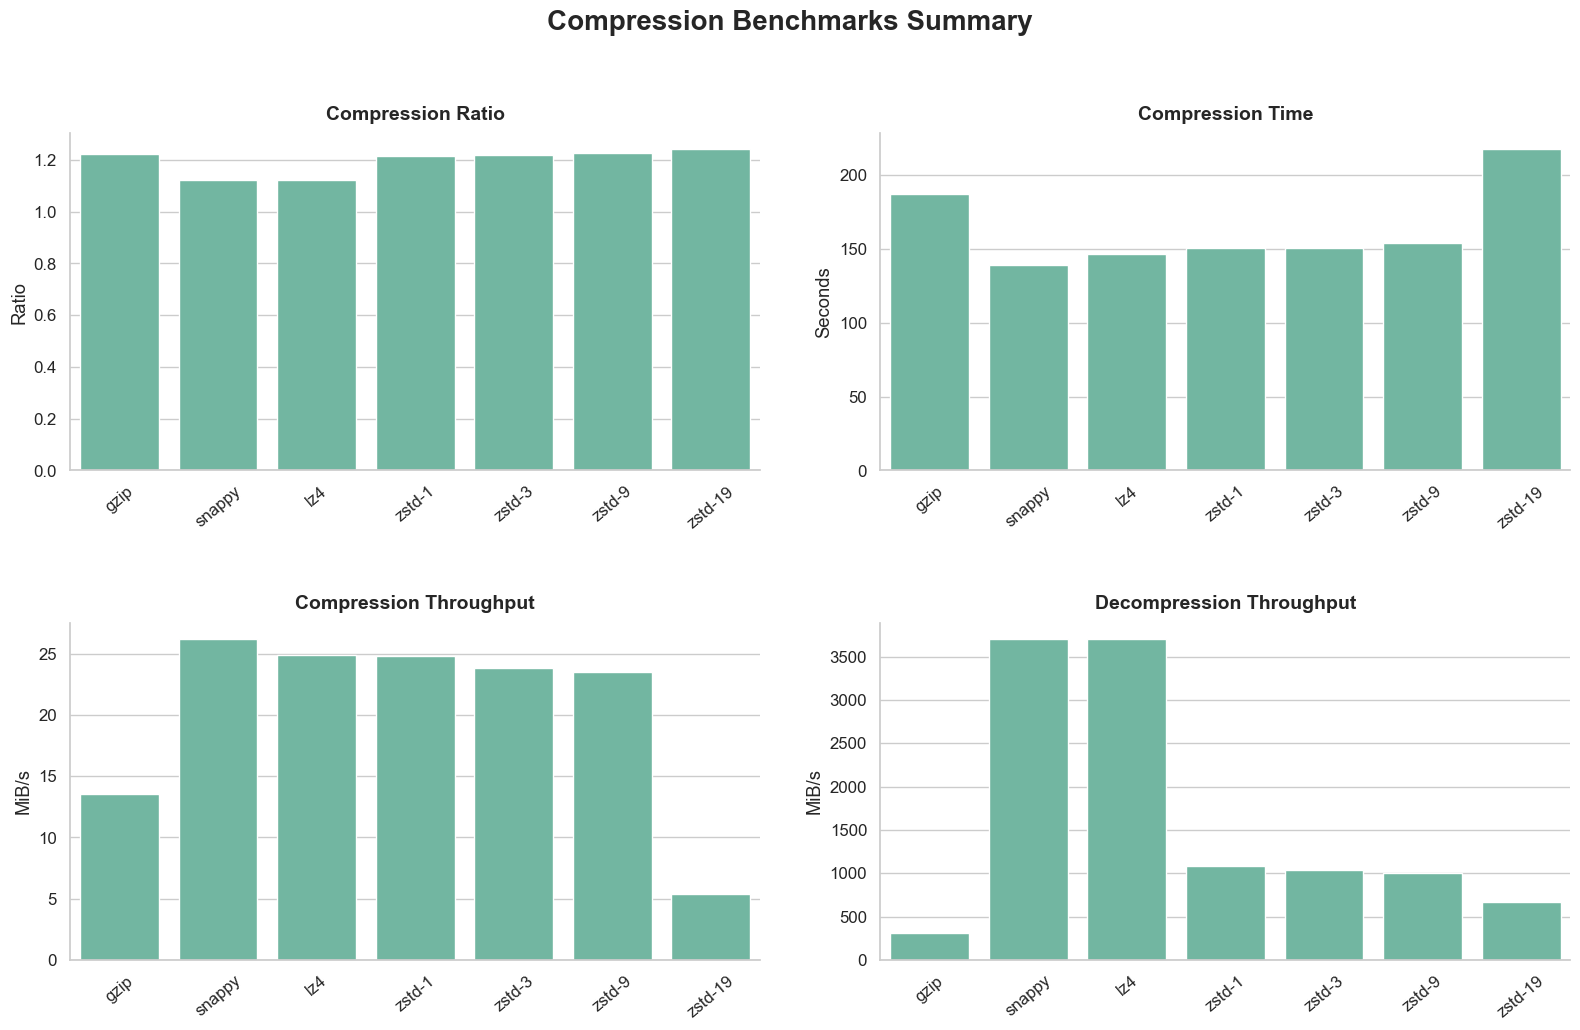

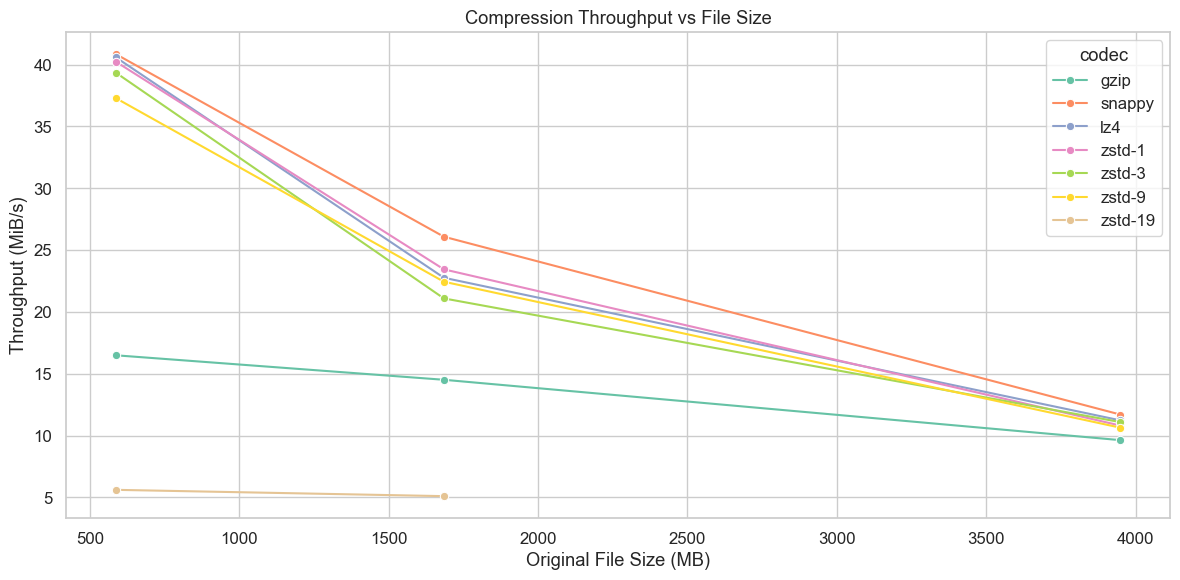

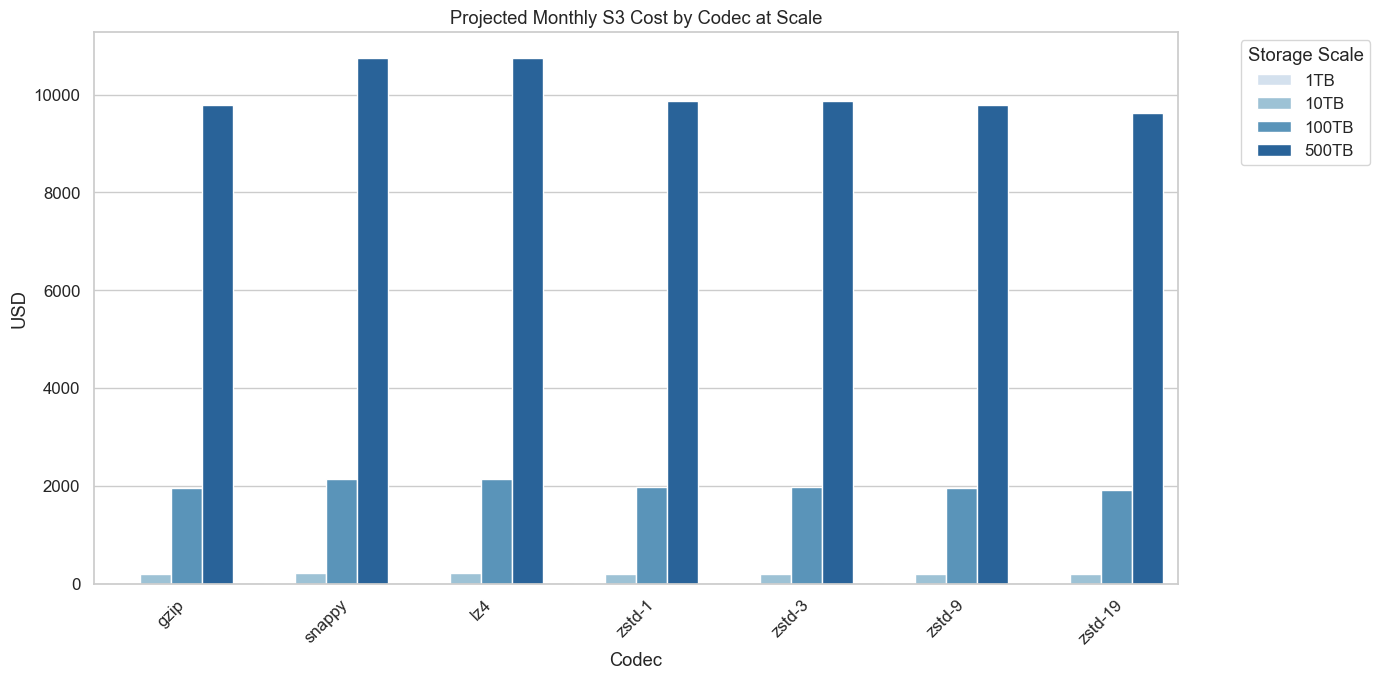

In [75]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Style
sns.set_theme(style="whitegrid", palette="Set2", font_scale=1.1)

# Load data
df = pd.read_csv("benchmark_results.csv")

# Normalize codec names
def normalize_codec(algo):
    if algo.startswith("zstd (level"):
        level = algo.split("level")[1].strip(" )")
        return f"zstd-{level}"
    return algo.lower()

df["codec"] = df["algorithm"].apply(normalize_codec)

# Filename & file labels
df["file_basename"] = df["input_file"].apply(os.path.basename)
file_label_map = {
    "yellow_tripdata_2024-01_uncompressed.parquet": "75MB Benchmark",
    "fhvhv_tripdata_2024-03_uncompressed.parquet": "586MB Benchmark",
    "benchmark_1gb_uncompressed.parquet": "1.6GB Benchmark",
    "benchmark_3gb_uncompressed.parquet": "3.9GB Benchmark",
    "benchmark_5gb_uncompressed.parquet": "6.6GB Benchmark"
}
df["file_label"] = df["file_basename"].map(file_label_map)

# Derived metrics
df["original_size_mb"] = df["original_size"] / (1024 * 1024)
df["original_size_gb"] = df["original_size"] / (1024**3)
df["compressed_size_mb"] = df["compressed_size"] / (1024 * 1024)
df["compressed_size_gb"] = df["compressed_size"] / (1024**3)
df["s3_cost_usd"] = df["compressed_size_gb"] * 0.0235
df["compression_efficiency"] = df["compression_ratio"] * df["compression_throughput"]

# Cost projection from 1.6GB reference
df_ref = df[df["file_label"] == "1.6GB Benchmark"].copy()
scales_tb = [1, 10, 100, 500]
for tb in scales_tb:
    col = f"s3_cost_usd_{tb}tb"
    df_ref[col] = (1 / df_ref["compression_ratio"]) * 1024 * tb * 0.0235

df_melted = df_ref.melt(
    id_vars=["codec"],
    value_vars=[f"s3_cost_usd_{tb}tb" for tb in scales_tb],
    var_name="scale",
    value_name="cost_usd"
)
df_melted["scale"] = df_melted["scale"].str.replace("s3_cost_usd_", "").str.replace("tb", "TB").str.upper()

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle("Compression Benchmarks Summary", fontsize=20, weight='bold', y=1.03)

def style_ax(ax, title, ylabel):
    ax.set_title(title, fontsize=14, weight='bold', pad=10)
    ax.set_xlabel("")
    ax.set_ylabel(ylabel)
    ax.tick_params(axis='x', rotation=40)
    sns.despine(ax=ax)

# Compression Ratio
sns.barplot(data=df, x="codec", y="compression_ratio", errorbar=None, ax=axes[0, 0])
style_ax(axes[0, 0], "Compression Ratio", "Ratio")

# Compression Time
sns.barplot(data=df, x="codec", y="compression_time", errorbar=None, ax=axes[0, 1])
style_ax(axes[0, 1], "Compression Time", "Seconds")

# Compression Throughput
sns.barplot(data=df, x="codec", y="compression_throughput", errorbar=None, ax=axes[1, 0])
style_ax(axes[1, 0], "Compression Throughput", "MiB/s")

# Decompression Throughput
sns.barplot(data=df, x="codec", y="decompression_throughput", errorbar=None, ax=axes[1, 1])
style_ax(axes[1, 1], "Decompression Throughput", "MiB/s")

plt.tight_layout(h_pad=3.5, w_pad=2.5)

# Throughput vs File Size
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x="original_size_mb", y="compression_throughput", hue="codec", marker="o")
plt.title("Compression Throughput vs File Size")
plt.xlabel("Original File Size (MB)")
plt.ylabel("Throughput (MiB/s)")
plt.tight_layout()

# Projected Cost Chart
plt.figure(figsize=(14, 7))
sns.barplot(data=df_melted, x="codec", y="cost_usd", hue="scale", palette="Blues", errorbar=None)
plt.title("Projected Monthly S3 Cost by Codec at Scale")
plt.ylabel("USD")
plt.xlabel("Codec")
plt.xticks(rotation=45)
plt.legend(title="Storage Scale", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

display(df_melted["cost_usd"])
